# ch13 tensorflow

In [3]:
import tensorflow as tf

import numpy as np

### testing on:

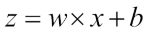

In [2]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                      shape=(None),
                      name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(.7, name='bias')
    
    z = w*x + b
    
    init = tf.global_variables_initializer()
    
with tf.Session(graph=g) as sess:
    sess.run(init)
    
    for t in [1.0, .6, -1.8]:
        print('x={} --> z={}'.format(t, sess.run(z, feed_dict={x:t})))

Instructions for updating:
Colocations handled automatically by placer.
x=1.0 --> z=2.700000047683716
x=0.6 --> z=1.9000000953674316
x=-1.8 --> z=-2.8999998569488525


### using arrays [ex. batchsize x 2 x 3]

In [9]:
g = tf.Graph()

with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                      shape=(None, 2, 3),
                      name='input_x')
    
    x2 = tf.reshape(x, shape=(-1, 6),
                   name='x2')
    
    # column sum
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    
    # column mean
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')
    
    
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    
    s = '''input shape: {}
    reshaped:\n{}
    column sums:\n{}
    column means:\n{}'''.format(x_array.shape,
                               sess.run(x2, feed_dict={x:x_array}),
                               sess.run(xsum, feed_dict={x:x_array}),
                               sess.run(xmean, feed_dict={x:x_array}))
    print(s)

input shape: (3, 2, 3)
    reshaped:
[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
    column sums:
[18. 21. 24. 27. 30. 33.]
    column means:
[ 6.  7.  8.  9. 10. 11.]


### ols using tensors

In [10]:
 X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                     2.0, 5.0, 6.3,
                     6.6, 7.4, 8.0,
                     9.0])

In [30]:
class TfLinearRegression(object):
    
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        
        self.g = tf.Graph()

        # init model
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()
            
    
    def build(self):
        self.X = tf.placeholder(dtype=tf.float32,
                               shape=(None, self.x_dim),
                               name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                               shape=(None),
                               name='y_input')
        w = tf.Variable(tf.zeros(shape=(1)),
                       name='weight')
        b = tf.Variable(tf.zeros(shape=(1)),
                       name='bias')
        
        print('x: {}\ny: {}\nw: {}\nb: {}'.format(self.X,
                                                  self.y,
                                                  w,
                                                  b))
        
        self.z_net = tf.squeeze(w*self.X + b,
                               name='z_net')
        sq_err = tf.square(self.y - self.z_net,
                          name='sq_err')
        print('z: {}\nsq_err: {}'.format(self.z_net,
                                        sq_err))
        
        self.mean_cost = tf.reduce_mean(sq_err,
                                       name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate,
                                                     name='GradientDescent')
        
        self.optimizer = optimizer.minimize(self.mean_cost)
        
    
    def get_sess(self):
        if hasattr(self, 'sess') == False:
            self.sess = tf.Session(graph=self.g)
        
        return self.sess
    
    
    def train(self, X_train, y_train, epochs=10):
        sess = self.get_sess()
        sess.run(self.init_op)
        
        training_costs= []
        for i in range(epochs):
            _, cost = sess.run([self.optimizer, self.mean_cost],
                              feed_dict={self.X:X_train,
                                        self.y:y_train})
            training_costs.append(cost)
        
        return training_costs
    
    
    def predict(self, X_test):
        sess = self.get_sess()
        y_pred = sess.run(self.z_net,
                         feed_dict={self.X:X_test})
        return y_pred

In [31]:
ols = TfLinearRegression(x_dim=X_train.shape[1], learning_rate=0.01)

x: Tensor("x_input:0", shape=(?, 1), dtype=float32)
y: Tensor("y_input:0", dtype=float32)
w: <tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
b: <tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
z: Tensor("z_net:0", dtype=float32)
sq_err: Tensor("sq_err:0", dtype=float32)


In [33]:
ols.train(X_train, y_train, epochs=10)

[32.431,
 6.0113096,
 1.446125,
 0.65659344,
 0.5193632,
 0.4948352,
 0.48978764,
 0.48811454,
 0.48703355,
 0.48606348]

In [35]:
ols.predict(X_train)

array([0.19570023, 1.2230239 , 2.2503474 , 3.2776709 , 4.3049946 ,
       5.3323183 , 6.3596416 , 7.3869653 , 8.414289  , 9.441613  ],
      dtype=float32)